# 서울시 따릉이 대여량 예측

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 확인하기

In [3]:
# 데이터 불러오기
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ttareungyi/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ttareungyi/test.csv')

In [4]:
# 데이터 개수 확인
print(train_df.shape)
print(test_df.shape)

(1459, 11)
(715, 10)


In [5]:
# feature 값 확인 
print(train_df.columns)
print('-'*100)
print(test_df.columns)

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5'],
      dtype='object')


 서울시 마포구의 날짜별, 시간별 기상상황과 따릉이 대여 수 데이터


- id 고유 id
- hour 시간 - 시간대대
- temperature 기온
- precipitation 비가 오지 않았으면 0, 비가 오면 1
- windspeed 풍속(평균)
- humidity 습도
- visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- ozone 오존
- pm10 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count 시간에 따른 따릉이 대여 수


ozone, pm10, pm2.5는 높을수록 안 좋다

train 데이터의 count를 제외하고는 feature 모두 같다.

count값을 예측해야한다

In [6]:
# 통계값 확인 
print(train_df.describe())

                id         hour  hour_bef_temperature  hour_bef_precipitation  \
count  1459.000000  1459.000000           1457.000000             1457.000000   
mean   1105.914325    11.493489             16.717433                0.031572   
std     631.338681     6.922790              5.239150                0.174917   
min       3.000000     0.000000              3.100000                0.000000   
25%     555.500000     5.500000             12.800000                0.000000   
50%    1115.000000    11.000000             16.600000                0.000000   
75%    1651.000000    17.500000             20.100000                0.000000   
max    2179.000000    23.000000             30.000000                1.000000   

       hour_bef_windspeed  hour_bef_humidity  hour_bef_visibility  \
count         1450.000000        1457.000000          1457.000000   
mean             2.479034          52.231297          1405.216884   
std              1.378265          20.370387           583.1317

In [7]:
# null 값 확인
print(train_df.info())
print('-'*100)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [8]:
# 결손값 개수 
print(train_df.isnull().sum())
print('-'*100)
print(test_df.isnull().sum())

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64
----------------------------------------------------------------------------------------------------
id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64


train, test 둘 다 id와 hour 값(count 제외)을 제외한 모든 feature에 결손값이 존재한다.


ozone, pm10, pm2.5를 제외한 나머지 데이터는 평균값으로 결손값을 채운다. 

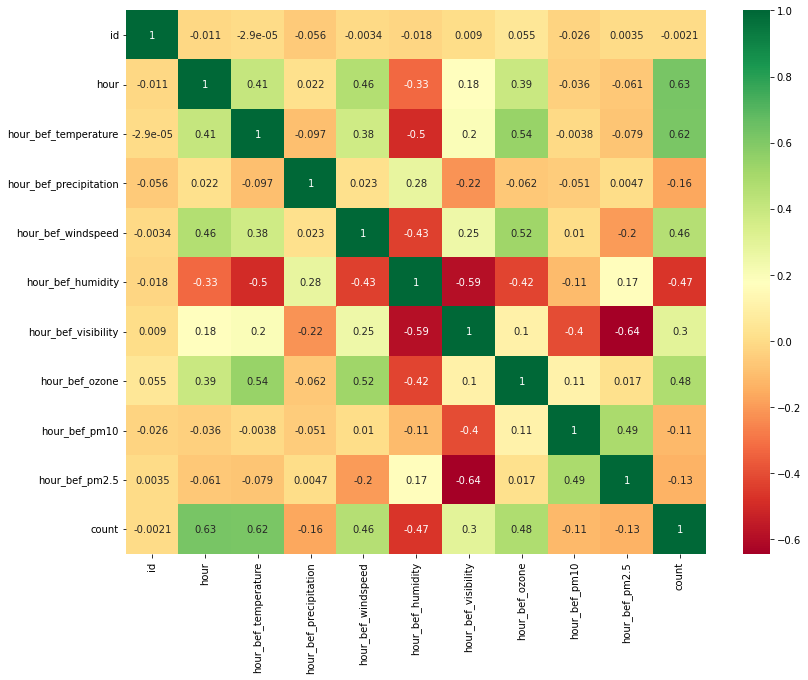

In [9]:
# heatmap을 통해 상관 관계 확인

plt.figure(figsize=(13,10))
g = sns.heatmap(train_df.corr(),annot=True,cmap="RdYlGn")

상관계수가 +_0.4 이상이면 상관관계가 있다고 봄

hour, temperature, windspeed, humidity, ozone


또한 visibility와 pm수치의 상관관계가 크다. 

null 값을 넣을 때 이를 이용해 넣는 것이 좋을 듯하다.

# 2. 데이터 시각화

Text(0.5, 1.0, 'hour_count')

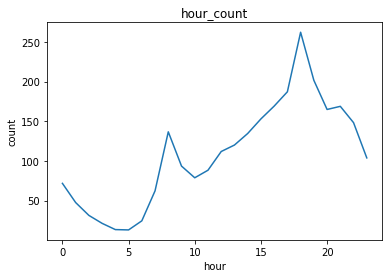

In [10]:
# 시간대에 따른 따릉이 대여량
train_df.groupby('hour').mean()['count'].plot()
plt.ylabel('count')
plt.title('hour_count')

그래프를 보면 5-10시 사이 뾰족한 부분은 출근시간, 15-20시 뾰족한 부분은 퇴근시간으로 볼 수 있다. 

즉, 출퇴근 시간에 따릉이 대여량 급증하는 것으로 볼 수 있다. 

또한 사람들의 활동량이 많아지는 10시 이후부터 대여량이 증가하고 퇴근시간 이후로는 대여량이 감소하는 것을 볼 수 있다. 
 

미세먼지의 결측값은 visibility의 값과의 비율로 임의로 넣겠다. 

In [11]:
# 각 feature의 비율 구하기(pm10, pm2.5, visiibility, ozone) -> 결측치를 이 비율로 넣을 거임 
def feature_per(feature_1 : str, feature_2 : str):
    # 모든 결측치가 있는 행을 제거하고 인덱스 복원
    train_and_test_dropna = [train_df.dropna().reset_index(drop=True), test_df.dropna().reset_index(drop=True)]
    per_list = []
    for dataset in train_and_test_dropna:
        # 각 index들의 feature끼리의 비율 
        for i in range(len(dataset)):
            f1 = dataset[feature_1][i]
            f2 = dataset[feature_2][i]
            per = f1 / f2
            per_list.append(per)
    # 각 비율들의 평균 
    mean_per = round(sum(per_list) / len(per_list), 4)
    return mean_per

pm2.5와 pm10은 visibility와 상관관계가 있음.

생각해보면 미세먼지가 높을수록 가시성이 안 좋음 

In [12]:
# pm10과 visibility의 비율 
feature_per('hour_bef_pm10', 'hour_bef_visibility')

0.056

In [13]:
# pm2.5와 visibility의 비율
feature_per('hour_bef_pm2.5', 'hour_bef_visibility')

0.0342

오존의 농도는 기온과 풍속의 상관관계가 있다. 

오존과 기온의 상관관계가 더 높기 때문에 이 비율로 결손값을 채우겠다.

In [14]:
# ozone과 temperature의 비율
feature_per('hour_bef_ozone', 'hour_bef_temperature')

0.0022

In [15]:
# 데이터 합치기 
train_and_test = [train_df, test_df]

# 결측치 있는 행들만 보기
def fill_value(feature_1 : str, feature_2 : str):
    for dataset in train_and_test:
        # null 값이 있는 index 리스트
        null_index = dataset[dataset[feature_1].isnull()].index
        # 비율 값으로 null 값 채우기 
        for i in null_index:
            dataset[feature_1] = dataset[feature_2] * feature_per(feature_1, feature_2) 
    print(train_df.isnull().sum())

feature 값 중 temperature, precipitation, windspeed,humidity,visibility는 결측값이 적음 

-> feature는 평균으로 채움

In [16]:
list = ['hour_bef_temperature', 'hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility']

# null 개수 별로 없는 feature 채우기 
for dataset in train_and_test:
    for i in list:
        dataset[i].fillna(round(dataset[i].mean(),0), inplace=True)
        dataset['hour_bef_precipitation'].fillna(0, inplace=True)

In [17]:
print(train_df.isnull().sum())

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64


In [18]:
# pm10 값 채우기 
fill_value('hour_bef_pm10', 'hour_bef_visibility')

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             76
hour_bef_pm10               0
hour_bef_pm2.5            117
count                       0
dtype: int64


In [19]:
# pm2.5 값 채우기
fill_value('hour_bef_pm2.5', 'hour_bef_visibility')

id                         0
hour                       0
hour_bef_temperature       0
hour_bef_precipitation     0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_visibility        0
hour_bef_ozone            76
hour_bef_pm10              0
hour_bef_pm2.5             0
count                      0
dtype: int64


In [20]:
fill_value('hour_bef_ozone', 'hour_bef_temperature')

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64


In [21]:
print(train_df.head(30))

    id  hour  hour_bef_temperature  hour_bef_precipitation  \
0    3    20                  16.3                     1.0   
1    6    13                  20.1                     0.0   
2    7     6                  13.9                     0.0   
3    8    23                   8.1                     0.0   
4    9    18                  29.5                     0.0   
5   13     2                  13.6                     0.0   
6   14     3                  10.6                     0.0   
7   16    21                  16.0                     0.0   
8   19     9                  13.8                     0.0   
9   20    14                  17.2                     0.0   
10  21     4                   5.7                     0.0   
11  22    10                  15.4                     0.0   
12  24     9                  14.1                     0.0   
13  27    10                   9.2                     0.0   
14  28     1                  20.0                     0.0   
15  29  

미세먼지 등급 조건 

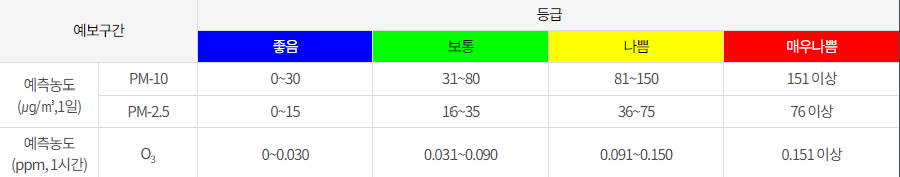

미세먼지, 오존을 등급 별로 나누어 보겠다

미세먼지(PM-10)

- 좋음(0) : 0 ~ 30
- 보통(1) : 31 ~ 80
- 나쁨(2) : 81 ~ 150
- 매우나쁨(3) : 151 ~ 

초미세먼지(PM-2.5)

- 좋음(0) : 0 ~ 15
- 보통(1) : 16 ~ 35
- 나쁨(2) : 36 ~ 75
- 매우나쁨(3) : 76 ~ 

오존
- 좋음(0) : 0 ~ 0.030
- 보통(1) : 0.031 ~ 0.090
- 나쁨(2) : 0.091 ~ 0.150
- 매우나쁨(3) : 0.151 ~ 


In [22]:
# 미세먼지 pm10 등급 별로 나누기 

for dataset in train_and_test:
    dataset.loc[dataset['hour_bef_pm10'] <= 30, 'hour_bef_pm10'] = 0
    dataset.loc[(dataset['hour_bef_pm10'] > 30) & (dataset['hour_bef_pm10'] <= 80), 'hour_bef_pm10'] = 1
    dataset.loc[(dataset['hour_bef_pm10'] > 80) & (dataset['hour_bef_pm10'] <= 150), 'hour_bef_pm10'] = 2
    dataset.loc[(dataset['hour_bef_pm10'] > 150), 'hour_bef_pm10'] = 3

train_df['hour_bef_pm10'].astype(int)
test_df['hour_bef_pm10'].astype(int)

0      1
1      1
2      0
3      1
4      0
      ..
710    1
711    2
712    1
713    2
714    1
Name: hour_bef_pm10, Length: 715, dtype: int64

In [23]:
# 미세먼지 pm2.5 등급 별로 나누기 

for dataset in train_and_test:
    dataset.loc[dataset['hour_bef_pm2.5'] <= 15, 'hour_bef_pm2.5'] = 0
    dataset.loc[(dataset['hour_bef_pm2.5'] > 15) & (dataset['hour_bef_pm2.5'] <= 35), 'hour_bef_pm2.5'] = 1
    dataset.loc[(dataset['hour_bef_pm2.5'] > 35) & (dataset['hour_bef_pm2.5'] <= 75), 'hour_bef_pm2.5'] = 2
    dataset.loc[(dataset['hour_bef_pm2.5'] > 75), 'hour_bef_pm2.5'] = 3
    
train_df['hour_bef_pm2.5'].astype(int)
test_df['hour_bef_pm2.5'].astype(int)

0      1
1      2
2      0
3      2
4      0
      ..
710    2
711    2
712    2
713    2
714    2
Name: hour_bef_pm2.5, Length: 715, dtype: int64

In [26]:
train_df.head(15)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.02934,0.0,1.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.03618,1.0,1.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.02502,1.0,2.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.01458,1.0,1.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.05310,2.0,2.0,431.0
5,13,2,13.6,0.0,1.7,80.0,1073.0,0.02448,1.0,1.0,39.0
6,14,3,10.6,0.0,1.5,58.0,1548.0,0.01908,1.0,2.0,23.0
7,16,21,16.0,0.0,6.0,21.0,1961.0,0.02880,2.0,2.0,146.0
8,19,9,13.8,0.0,1.9,64.0,1344.0,0.02484,1.0,2.0,39.0
9,20,14,17.2,0.0,2.1,32.0,1571.0,0.03096,1.0,2.0,83.0


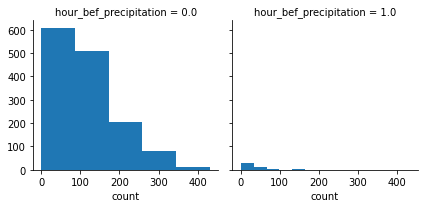

In [25]:
# 강수에 따른 대여량
g = sns.FacetGrid(train_df, col='hour_bef_precipitation')
g.map(plt.hist, 'count', bins=5)


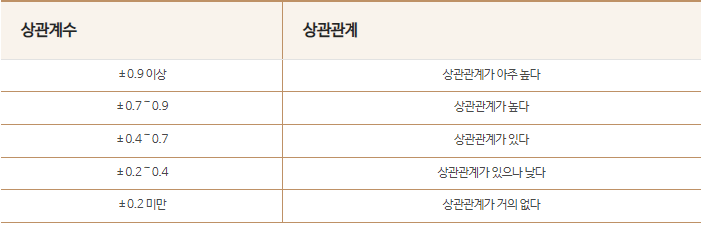